 # Individual Experimentation
 Name: Vinal Asodia <br>
 Username: va00191 <br>
 URN: 6539526
 
#### Import Modules

In [1]:
import pickle
import pandas as pd
import numpy as np
import utils
import keras
import h5py
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Conv1D, Dropout, Conv1D, GlobalMaxPooling1D, Embedding, LSTM, SpatialDropout1D
import matplotlib.pyplot as plt
%matplotlib inline

#### Define Constants

In [2]:
TRAIN_DATASET = "train.csv"
TEST_DATA = "test.csv"
TEST_LABELS = "test_labels.csv"
REDUNDANT_FIELDS = ["id"]
DATA_FIELD = ["comment_text"]
LABEL_FIELDS = ["toxic","severe_toxic","obscene","threat","insult","identity_hate"]

NUM_WORDS = 20000
EMBEDDING_DIM = 100
MAX_WORD = 200

BATCH_SIZE = 32
EPOCHS = 10

N_SPLITS = 10
N_REPEATS = 3
RANDOM_STATE = None

# Data Preparation

#### Read in the dataset
The dataset can be download here (https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge) <br>
The dataset comes in 3 csv files, the training dataset, the test comments and the test labels

In [24]:
# Read in training dataset
train = pd.read_csv(TRAIN_DATASET)

# Read in test data and labels
test_data = pd.read_csv(TEST_DATA)
test_labels = pd.read_csv(TEST_LABELS)

# Combine test data and labels into one data frame
test = pd.concat([test_data, test_labels], axis=1)

# Remove redundant id field from both datasets
train = train.drop(columns=REDUNDANT_FIELDS)
test = test.drop(columns=REDUNDANT_FIELDS)

# Remove samples with labels containing -1 in test dataset, this 
# is a place holder for samples that were not assigned labels.
test = test.drop(test[(test.toxic == -1) |
                      (test.severe_toxic == -1) |
                      (test.obscene == -1) |
                      (test.threat == -1) |
                      (test.insult == -1) |
                      (test.identity_hate == -1)].index)

#### Visualise the initial class balance

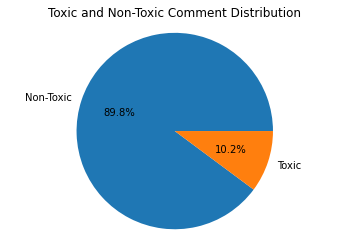

In [25]:
# Gather all samples that have no toxic labels, these can be consider "non-toxic"
non_toxic = train[(train.toxic == 0) &
                  (train.severe_toxic == 0) & 
                  (train.obscene == 0) & 
                  (train.threat == 0) & 
                  (train.insult == 0) & 
                  (train.identity_hate == 0)]

# Gather all samples that are labelled
toxic = train[(train.toxic == 1) |
                  (train.severe_toxic == 1) | 
                  (train.obscene == 1) | 
                  (train.threat == 1) | 
                  (train.insult == 1) | 
                  (train.identity_hate == 1)]

labels = ["Non-Toxic", "Toxic"]
data = [len(non_toxic), len(toxic)]

plt.pie(data,labels=labels,autopct='%1.1f%%')
plt.title('Toxic and Non-Toxic Comment Distribution')
plt.axis('equal')
plt.show()

In [26]:
classes = {}

for index in range(1,7):
    classes.update({train.iloc[:,index].name : np.histogram(train.iloc[:,index], bins=2)[0]})

classes

{'toxic': array([144277,  15294], dtype=int64),
 'severe_toxic': array([157976,   1595], dtype=int64),
 'obscene': array([151122,   8449], dtype=int64),
 'threat': array([159093,    478], dtype=int64),
 'insult': array([151694,   7877], dtype=int64),
 'identity_hate': array([158166,   1405], dtype=int64)}

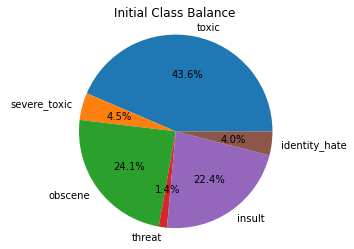

In [27]:
labels = list(classes.keys())
values = list(classes.values())
data = [values[x][1] for x in range(0,len(values))]

plt.pie(data,labels=labels,autopct='%1.1f%%')
plt.title('Initial Class Balance')
plt.axis('equal')
plt.show()

#### Balance the classes
From the visuals it is clear that the number of non-toxic samples (89.8%) greatly outweigh comments that are toxic in any way (10.2%). A large amount of non-toxic comments need to be dropped to address this.

There is also an imbalance between the different toxic labels. The "toxic" label is the most present (with 43.6%), which is expected as comments that are obscene, insulting, attack identity or a threat can also be seen as toxic. There are very few examples of comments with the labels "severe_toxic", "identity_hate" or "threat" (4.5%, 4.0% and 1.4% respectively), meaning samples from the other labels should be dropped to balance the classes.

In [28]:
# Drop toxic samples
train = train.drop(train[(train.toxic == 1) & 
                          (train.severe_toxic != 1) & 
                          (train.threat != 1) & 
                          (train.obscene != 1) &
                          (train.insult != 1) &
                          (train.identity_hate != 1)].index[:6000])

# Drop obscene samples
train = train.drop(train[(train.toxic == 1) & 
                          (train.severe_toxic != 1) & 
                          (train.threat != 1) & 
                          (train.obscene == 1) &
                          (train.insult != 1) &
                          (train.identity_hate != 1)].index[:3000])

# Drop insult samples
train = train.drop(train[(train.toxic == 1) & 
                          (train.severe_toxic != 1) & 
                          (train.threat != 1) & 
                          (train.obscene != 1) &
                          (train.insult == 1) &
                          (train.identity_hate != 1)].index[:3000])

# Drop non-toxic samples
train = train.drop(train[(train.toxic != 1) & 
                          (train.severe_toxic != 1) & 
                          (train.threat != 1) & 
                          (train.obscene != 1) &
                          (train.insult != 1) &
                          (train.identity_hate != 1)].index[:100000])


#### Visualise the new class balance

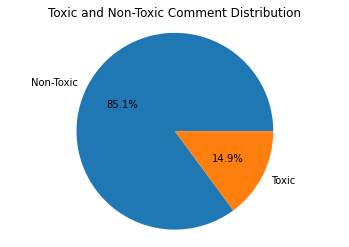

In [29]:
# Gather all samples that have no toxic labels, these can be consider "non-toxic"
non_toxic = train[(train.toxic == 0) &
                  (train.severe_toxic == 0) & 
                  (train.obscene == 0) & 
                  (train.threat == 0) & 
                  (train.insult == 0) & 
                  (train.identity_hate == 0)]

# Gather all samples that are labelled
toxic = train[(train.toxic == 1) |
                  (train.severe_toxic == 1) | 
                  (train.obscene == 1) | 
                  (train.threat == 1) | 
                  (train.insult == 1) | 
                  (train.identity_hate == 1)]

labels = ["Non-Toxic", "Toxic"]
data = [len(non_toxic), len(toxic)]

plt.pie(data,labels=labels,autopct='%1.1f%%')
plt.title('Toxic and Non-Toxic Comment Distribution')
plt.axis('equal')
plt.show()

In [30]:
classes2 = {}

for index in range(1,7):
    classes2.update({train.iloc[:,index].name : np.histogram(train.iloc[:,index], bins=2)[0]})

classes2

{'toxic': array([44277,  6655], dtype=int64),
 'severe_toxic': array([49337,  1595], dtype=int64),
 'obscene': array([44241,  6691], dtype=int64),
 'threat': array([50454,   478], dtype=int64),
 'insult': array([44270,  6662], dtype=int64),
 'identity_hate': array([49527,  1405], dtype=int64)}

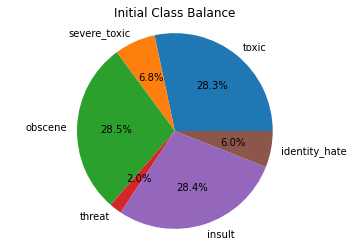

In [31]:
labels = list(classes2.keys())
values = list(classes2.values())
data = [values[x][1] for x in range(0,len(values))]

plt.pie(data,labels=labels,autopct='%1.1f%%')
plt.title('Initial Class Balance')
plt.axis('equal')
plt.show()

#### Normalise and Clean Dataset

In [55]:
# Remove punctuation
regex_str = "[^a-zA-Z\s]"
train['comment_text'] = train['comment_text'].replace(regex=regex_str, value="")

# Remove extra whitespaces
regex_space = "\s+"
train['comment_text'] = train['comment_text'].replace(regex=regex_space, value=" ")

# Strip whitespaces
train['comment_text'] = train['comment_text'].str.strip()

# Lowercase
train['comment_text'] = train['comment_text'].str.lower()

# Convert comment_text column into a list
comment_list = train['comment_text'].tolist()

print(comment_list[898])

if we do win and get these evil people out of the government and their private forces as well then perhaps there wont be any nuclear blasts across the us and europe btw if mongo is really with hs why is he on wikipedia


In [17]:
comments = [sentence.split() for sentence in comment_list]
tokenised_comment = [word for sentence in comments for word in sentence]

#### Remove Stopwords

In [18]:
# Remove stopwords, using stopword list from nltk
stopword_list = set(stopwords.words('english'))
removed_stopwords = [word for word in tokenised_comment if word not in stopword_list]

#### Visualise the top words for each label

#### Create N-Grams

#### Visualise the Top N-Grams

#### Tokenise Dataset

#### Lemmatise Dataset

In [6]:
train,test = utils.read_datasets()
x_train = pickle.load(open("comment_lemma.pickle", "rb"))
y_train = train[LABEL_FIELDS]
y_train = y_train.to_numpy()

tokenizer = Tokenizer(NUM_WORDS)
tokenizer.fit_on_texts(x_train)
corpus = tokenizer.word_index
reverse_corpus = dict(map(reversed, corpus.items()))

x_sequences_train = tokenizer.texts_to_sequences(x_train)
x_padded_train = keras.preprocessing.sequence.pad_sequences(x_sequences_train, maxlen= 150)
x_padded_train = np.array(x_padded_train)

In [4]:
type(y_train)

numpy.ndarray

# LSTM Model

In [12]:
model = Sequential()
model.add(Embedding(NUM_WORDS, EMBEDDING_DIM, input_length=200))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(6, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 5
batch_size = 64

history = model.fit(x_padded_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


Epoch 1/5
101/101 [==============================] - 34s 333ms/step - loss: 0.5068 - accuracy: 0.3920 - val_loss: 0.1232 - val_accuracy: 0.0322
Epoch 2/5
101/101 [==============================] - 36s 360ms/step - loss: 0.3169 - accuracy: 0.4487 - val_loss: 0.0609 - val_accuracy: 0.0350
Epoch 3/5
101/101 [==============================] - 36s 360ms/step - loss: 0.2737 - accuracy: 0.4381 - val_loss: 0.0692 - val_accuracy: 0.1485
Epoch 4/5
101/101 [==============================] - 37s 364ms/step - loss: 0.2375 - accuracy: 0.4603 - val_loss: 0.0336 - val_accuracy: 0.0518
Epoch 5/5
101/101 [==============================] - 37s 367ms/step - loss: 0.1996 - accuracy: 0.3956 - val_loss: 0.0303 - val_accuracy: 0.0560


 # Leave One Out Cross Validation (LOOCV)
 Too many samples to use LOOCV, takes roughly 4.5 minutes for 1 sample.... for roughly 7200 samples it would take 32,400 minutes, which 540 hours, which is 22.5 days..... yeah no
 
 One work around could be lower the number of epochs and increase the batch size, but maybe just move onto other cross validation techniques.

# Experiment Setup 1: Cross Validation

In [12]:
accr, losses = [], []
y_pred,y_true = [], []
modelKFOLD = utils.build_model(NUM_WORDS)
kf = RepeatedKFold(n_splits=N_SPLITS,n_repeats=N_REPEATS,random_state=RANDOM_STATE)

for train_index, val_index in kf.split(x_padded_train):
    X, X_val = x_padded_train[train_index], x_padded_train[val_index]
    y, y_val = y_train[train_index], y_train[val_index]
    modelKFOLD.fit(X, y, batch_size=BATCH_SIZE, epochs=EPOCHS)
    pred = modelKFOLD.evaluate(X_val,y_val)
    prediction = modelKFOLD.predict(X_val)
    print("Loss: ",pred[0])
    print("Accuracy: ",pred[1])
    losses.append(pred[0])
    accr.append(pred[1])
    y_pred.append(prediction)
    y_true.append(y_val)

Epoch 1/10
201/201 [==============================] - 11s 55ms/step - loss: 0.4968 - accuracy: 0.3375
Epoch 2/10
201/201 [==============================] - 11s 56ms/step - loss: 0.3659 - accuracy: 0.4227
Epoch 3/10
201/201 [==============================] - 12s 59ms/step - loss: 0.3238 - accuracy: 0.4434
Epoch 4/10
201/201 [==============================] - 12s 58ms/step - loss: 0.3007 - accuracy: 0.4570
Epoch 5/10
201/201 [==============================] - 13s 62ms/step - loss: 0.2889 - accuracy: 0.4645
Epoch 6/10
201/201 [==============================] - 13s 63ms/step - loss: 0.2757 - accuracy: 0.4794
Epoch 7/10
201/201 [==============================] - 13s 62ms/step - loss: 0.2639 - accuracy: 0.4816
Epoch 8/10
201/201 [==============================] - 13s 65ms/step - loss: 0.2513 - accuracy: 0.4945
Epoch 9/10
201/201 [==============================] - 12s 61ms/step - loss: 0.2367 - accuracy: 0.4908
Epoch 10/10
23/23 [==============================] - 0s 9ms/step - loss: 0.4430 - 

In [16]:
print(y_pred[0][0].round())
print(y_true[0][0])

[1. 0. 1. 0. 1. 1.]
[1 1 1 0 1 0]


In [14]:
print(sum(losses)/len(losses))
print(sum(accr)/len(accr))

0.12279526169101397
0.43713180522123973


In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i],
                                                        y_score[:, i])
    average_precision[i] = average_precision_score(Y_test[:, i], y_score[:, i])